<h1 style="color: #001a79;">Topic 4 - Machine Learning Project Notebook</h1>

In [12]:
# Efficient numerical arrays.
import numpy as np

# Dataframes for data manipulation and analysis.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting.
import matplotlib.pyplot as plt

import seaborn as sns

<h3 style="color: #001a79;">Introduction</h3>

<hr style="border-top: 1px solid #001a79;" />

Comeback to

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

<h3 style="color: #001a79;">Numenta Anomaly Benchmark (NAB) Dataset</h3>

<hr style="border-top: 1px solid #001a79;" />

- The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. 
- It is comprised of over 50 labeled real-world and artificial timeseries data files. 
- Plus a novel scoring mechanism designed for real-time applications.
- All of the data and code is fully open-source, with extensive documentation, and a scoreboard of anomaly detection algorithms found <a href="https://github.com/numenta/NAB" target="_blank">here</a>. 

Source: <a href="https://www.kaggle.com/datasets/boltzmannbrain/nab" target="_blank">Kaggle: Numenta Anomaly Benchmark (NAB) Dataset</a>

<h3 style="color: #001a79;">Loading the Data</h3>

<hr style="border-top: 1px solid #001a79;" />

To demonstrate anomaly detection effectively we will use two datasets from the Numenta Anomaly Benchmark (NAB) Dataset. 

1. <a href="https://github.com/numenta/NAB/blob/master/data/artificialNoAnomaly/art_daily_small_noise.csv" target="_blank">`art_daily_small_noise.csv`</a> file for training.
2. <a href="https://github.com/numenta/NAB/blob/master/data/artificialWithAnomaly/art_daily_jumpsup.csv" target="_blank">`the art_daily_jumpsup.csv`</a> file for testing.

### `df_small_noise`

In [61]:
# These CSVs can be found at the follow URL.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

In [62]:
# art_daily_small_noise.csv data file url.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

In [64]:
# Import and save data as a df - df_small_noise. 
# parse_dates=True will tell pandas you are importing a date while index_col="timestamp" sets timestamp as the index. 
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True)

#index_col="timestamp"

# Print 
df_small_noise

,timestamp,value
0,2014-04-01 00:00:00,18.324919
1,2014-04-01 00:05:00,21.970327
2,2014-04-01 00:10:00,18.624806
3,2014-04-01 00:15:00,21.953684
4,2014-04-01 00:20:00,21.909120
...,...,...
4027,2014-04-14 23:35:00,20.211195
4028,2014-04-14 23:40:00,20.531041
4029,2014-04-14 23:45:00,19.032127
4030,2014-04-14 23:50:00,21.798801


In [ ]:
sns.lineplot(data = df_small_noise, x = 'timestamp', y = 'value')

<AxesSubplot:xlabel='timestamp', ylabel='value'>

`df_small_noise` contains 4,032 rows of data with 2 columns `timestamp` (the index) and `value`. 

`timestamp` - Is the dataframes index and represents a **date and time** formatted as Year-Month-Day (YYYY-MM-DD) and Hours:Minutes:Seconds (hh:mm:ss). 

The timestamp starts at the 1st of April 2014 at 12:00am and increments by 5 minutes at each row. The last data point on 14th of April 2014 at 12:55pm. 

Therefore for 14 days, every 5 minutes a value is recorded. 
- Every hour 12 values are recorded. 
- Every day 288 values are recorded. 
- So in 14 days 4,032 values are recorded in total.

`value` - 

In [65]:
# This just sets the default plot size to be bigger.
plt.rcParams['figure.figsize'] = (12, 8)

# Sets the style of chart in Seaborn 
sns.set(style="darkgrid") 

TypeError: plot got an unexpected keyword argument 'x'

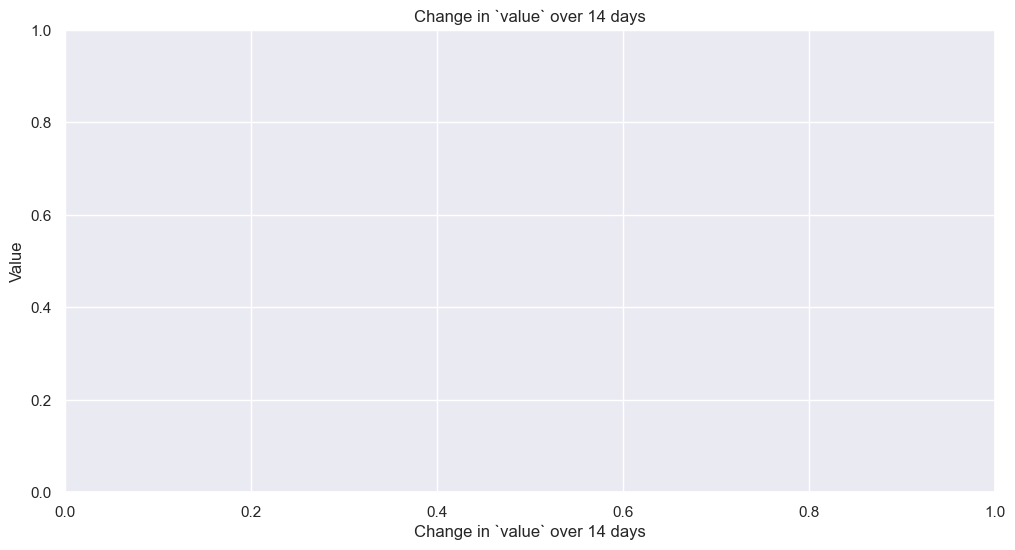

In [69]:
# Create a plot. 
fig, ax = plt.subplots(figsize=(12,6))

#xi = list(range(len(days)))
#days = ["01 Apr 2014", "02 Apr 2014", "03 Apr 2014", "04 Apr 2014", "05 Apr 2014", "06 Apr 2014", "07 Apr 2014", 
#        "08 Apr 2014", "09 Apr 2014", "10 Apr 2014", "11 Apr 2014", "12 Apr 2014", "13 Apr 2014", "14 Apr 2014"]

# Use pandas to plot data frame.
plt.title("Change in `value` over 14 days")

plt.xlabel("Change in `value` over 14 days")
plt.ylabel("Value")
#plt.xticks(xi, days)

plt.plot(x = df_small_noise['timestamp'], y = df_small_noise['value'], legend=False, ax=ax)

#plt.xticks(("01 Apr 2014", "02 Apr 2014", "03 Apr 2014", "04 Apr 2014", "05 Apr 2014", "06 Apr 2014", "07 Apr 2014", 
#        "08 Apr 2014", "09 Apr 2014", "10 Apr 2014", "11 Apr 2014", "12 Apr 2014", "13 Apr 2014", "14 Apr 2014"))

plt.show()

### `df_daily_jumpsup` 

In [6]:
# art_daily_jumpsup.csv data file url.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

# Import and save data as a df - df_daily_jumpsup. 
df_daily_jumpsup  = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

# Print 
df_daily_jumpsup

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


`df_daily_jumpsup` also contains 4,032 rows of data with 2 columns `timestamp` (the index) and `value`. 